# Data inspection

**Define the config parameters**

In [1]:
import torch

IMAGE_SIZE = 224
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 25
NUMBER_OF_CLASSES = 2
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

DATA_PATH = '/kaggle/input/melanoma-cancer-dataset'

**Get class distribution**


In [2]:
import os

def get_data_distribution(data):
    data_path = data
    class_counts = {}

    for class_label in os.listdir(data_path):
        class_path = os.path.join(data_path, class_label)
        number_of_images = len(os.listdir(class_path))
        class_counts[class_label] = number_of_images

    for class_name, counts in class_counts.items():
        print(f"Class: {class_name}, Number of images: {counts}")
        
    return class_counts
        
class_counts = get_data_distribution(os.path.join(DATA_PATH, 'train'))

Class: Benign, Number of images: 6289
Class: Malignant, Number of images: 5590


**Plot class distribution**

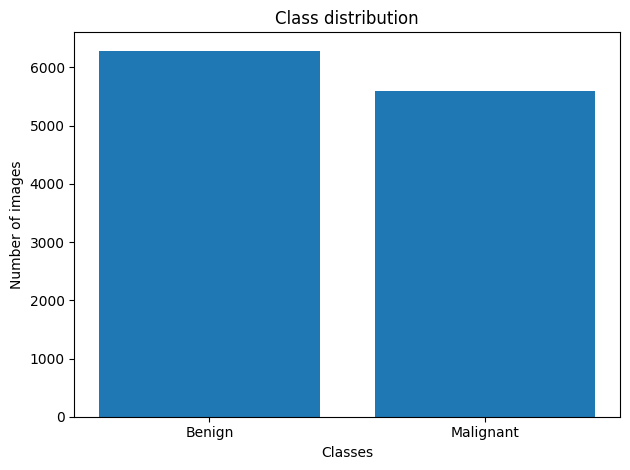

In [3]:
import matplotlib.pyplot as plt

def plot_distribution(class_counts):
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Class distribution')
    plt.tight_layout()
    plt.show()
    
plot_distribution(class_counts)

**Plot 5 images from each class for inspection**

In [4]:
def visualize_classes(data):
    dict_for_five_item_in_each_class = {}
    for class_label in os.listdir(data):
        class_path = os.path.join(data, class_label)
        items_paths = []
        for idx, item in enumerate(os.listdir(class_path)):
            if idx < 5:
                items_paths.append(os.path.join(class_path, item))
        dict_for_five_item_in_each_class[class_label] = items_paths
    
    return dict_for_five_item_in_each_class

dict_for_five_item_in_each_class = visualize_classes(os.path.join(DATA_PATH, 'train'))

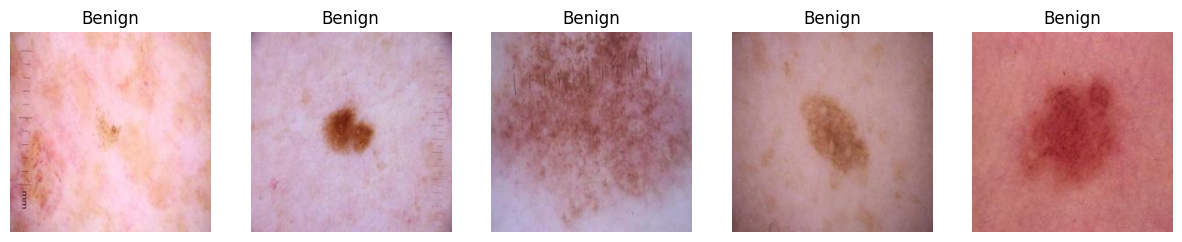

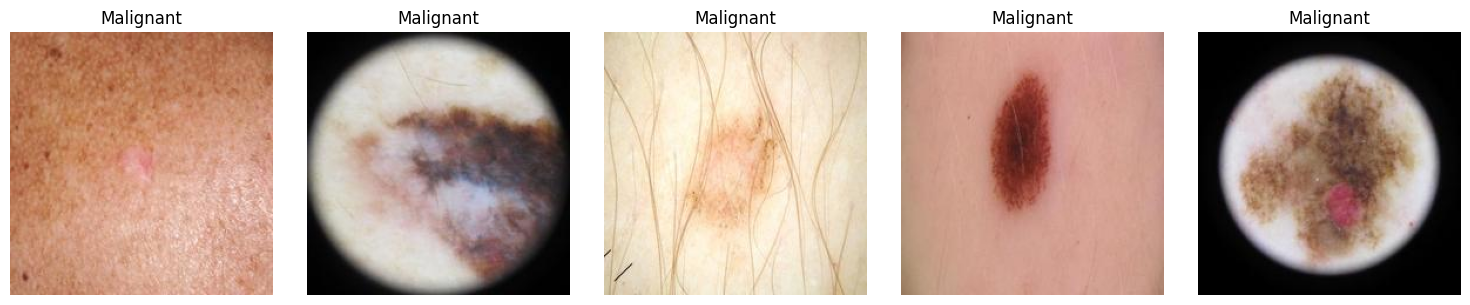

In [5]:
import PIL

def plot_5_images_from_each_class(dict_for_five_item_in_each_class):
    for class_labels, image_paths in dict_for_five_item_in_each_class.items():
        plt.figure(figsize=(15, 3))
        for i, image_path in enumerate(image_paths):
            img = PIL.Image.open(image_path)
            plt.subplot(1, len(image_paths), i + 1)
            plt.imshow(img)
            plt.title(class_labels)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_5_images_from_each_class(dict_for_five_item_in_each_class)

# Load the data

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.GaussianBlur(kernel_size=3),
    # transforms.RandomAffine(degrees=0, shear=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])


def get_dataloaders():
    train_path = os.path.join(DATA_PATH, 'train')
    test_path = os.path.join(DATA_PATH, 'test')

    full_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

    # Splitting the train data to train and validation data
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f'Length of train_dataset: {len(train_dataset)}')
    print(f'Length of Validation dataset: {len(val_dataset)}')
    print(f'Length of test dataset: {len(test_dataset)}')

    return train_loader, val_loader, test_loader

**Function for model saving and loading**

In [7]:
def save_model(save_directory, model,  number_of_epochs, additional_text='', augmentation=''):
    os.makedirs(save_directory, exist_ok=True)
    model_name = model.__class__.__name__

    torch.save(model.state_dict(), os.path.join(save_directory, f"{model_name}{additional_text}_model_epochs_{number_of_epochs}{augmentation}.pth"))


def load_model(load_directory, model, number_of_epochs, additional_text='', augmentation=''):
    model_name = model.__class__.__name__

    model.load_state_dict(torch.load(os.path.join(load_directory, f"{model_name}{additional_text}_model_epochs_{number_of_epochs}{augmentation}.pth"), map_location=torch.device('cpu')))

# Training

In [8]:
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler


def plot_and_save_training_results(data, label, num_epochs, save_path):
    plt.plot(range(1, num_epochs + 1), data['train'], label='train')
    plt.plot(range(1, num_epochs + 1), data['val'], label='validation')
    plt.title(f'Training and validation {label}')
    plt.xlabel('epoch')
    plt.ylabel(label)
    plt.legend()

    plt.savefig(os.path.join(save_path, f"{label}.png"))
    plt.close()

    print(f"Training graph saved to {save_path}")


def train_val_step(dataloader, model, loss_function, optimizer, device, scaler=None):
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    running_loss = 0
    correct = 0
    total = 0

    for data in dataloader:
        image, labels = data
        image, labels = image.to(device), labels.to(device)
        # Uncomment it when you use BCEWithLogitsLoss() criterion
#         labels = labels.unsqueeze(1).float()

        with autocast():
            outputs = model(image)
            loss = loss_function(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if optimizer is not None:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item()

    return running_loss / len(dataloader.dataset), correct / total


def train(model, train_loader, val_loader, device, num_epochs=5, additional_text='', augmentation=''):

    graphs_and_logs_save_directory = './training_graphs_and_logs'
    model_name = model.__class__.__name__
    graphs_and_logs_save_path = os.path.join(graphs_and_logs_save_directory, f"{model_name}_epochs_{num_epochs}")

    model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES)
    # model_selector(model, 2)

    # define criterion and optimizer for training
    criterion = torch.nn.CrossEntropyLoss()
    # criterion = nn.BCEWithLogitsLoss()


    # model = nn.DataParallel(model).to(device)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

    scheduler = ReduceLROnPlateau(optimizer, threshold=0.01, factor=0.1, patience=3, min_lr=1e-6, verbose=True)

    scaler = GradScaler()

    accuracy_tracking = {'train': [], 'val': []}
    loss_tracking = {'train': [], 'val': []}
    best_loss = float('inf')
    num_of_actual_epochs = 1

    # Early stopping
    early_stopping = False
    patience = 5
    min_delta = 0.00001
    current_patience = 0

    os.makedirs(graphs_and_logs_save_path, exist_ok=True)

    log_file_path = os.path.join(graphs_and_logs_save_path, 'log.txt')
    log_file = open(log_file_path, 'a')

    # we iterate for the specified number of epochs
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        training_loss, training_accuracy = train_val_step(train_loader, model, criterion, optimizer, device, scaler)
        loss_tracking['train'].append(training_loss)
        accuracy_tracking['train'].append(training_accuracy)

        with torch.inference_mode():
            val_loss, val_accuracy = train_val_step(val_loader, model, criterion, None, device)
            loss_tracking['val'].append(val_loss)
            accuracy_tracking['val'].append(val_accuracy)
            if val_loss < best_loss - min_delta:
                best_loss = val_loss
                current_patience = 0

                # Save the model when a new best loss is found
                print('Saving best model')
                save_model('./trained_models', model, num_epochs, additional_text=additional_text,
                           augmentation=augmentation)
            else:
                current_patience += 1

                # Early stopping
            if current_patience >= patience:
                print('Early stopping triggered.')
                early_stopping = True
                break

            scheduler.step(val_loss)

        print(f'Training accuracy: {training_accuracy:.6}, Validation accuracy: {val_accuracy:.6}')
        print(f'Training loss: {training_loss:.6}, Validation loss: {val_loss:.6}')

        # Append the information to the log file
        log_file.write(f"Epoch {epoch + 1}: "
                       f'Training accuracy: {training_accuracy:.6}, Validation accuracy: {val_accuracy:.6}, '
                       f'Training loss: {training_loss:.6}, Validation loss: {val_loss:.6}\n')

        num_of_actual_epochs += 1

    print('\nFinished Training\n')

    if early_stopping:
        plot_and_save_training_results(loss_tracking, 'loss', num_of_actual_epochs, graphs_and_logs_save_path)
        plot_and_save_training_results(accuracy_tracking, 'accuracy', num_of_actual_epochs, graphs_and_logs_save_path)
    else:
        plot_and_save_training_results(loss_tracking, 'loss', num_epochs, graphs_and_logs_save_path)
        plot_and_save_training_results(accuracy_tracking, 'accuracy', num_epochs, graphs_and_logs_save_path)

    log_file.close()


if __name__ == "__main__":
    # model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    # model = models.mobilenet_v3_large()

    model = models.resnet18(weights='IMAGENET1K_V1')
    # model = models.resnet34(weights='IMAGENET1K_V1')
    # model = models.mobilenet_v3_large(pretrained=True)
    # model = models.mobilenet_v2(pretrained=True)
    # model = models.efficientnet_v2_l(weights='IMAGENET1K_V1')

    train_loader, val_loader, _ = get_dataloaders()
    train(model, train_loader, val_loader, DEVICE, num_epochs=NUMBER_OF_EPOCHS, augmentation='aug')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


Length of train_dataset: 9504
Length of Validation dataset: 2375
Length of test dataset: 2000


Epochs:   4%|▍         | 1/25 [01:03<25:12, 63.03s/epoch]

Saving best model
Training accuracy: 0.788089, Validation accuracy: 0.839158
Training loss: 0.00735984, Validation loss: 0.00588718


Epochs:   8%|▊         | 2/25 [01:26<15:13, 39.70s/epoch]

Saving best model
Training accuracy: 0.850168, Validation accuracy: 0.861895
Training loss: 0.00545151, Validation loss: 0.0049044


Epochs:  12%|█▏        | 3/25 [01:49<11:45, 32.09s/epoch]

Saving best model
Training accuracy: 0.861111, Validation accuracy: 0.876632
Training loss: 0.00496602, Validation loss: 0.0046411


Epochs:  16%|█▌        | 4/25 [02:12<10:01, 28.66s/epoch]

Saving best model
Training accuracy: 0.86532, Validation accuracy: 0.876632
Training loss: 0.00470929, Validation loss: 0.00450902


Epochs:  20%|██        | 5/25 [02:35<08:50, 26.54s/epoch]

Training accuracy: 0.875947, Validation accuracy: 0.879158
Training loss: 0.00450633, Validation loss: 0.00459284


Epochs:  24%|██▍       | 6/25 [02:58<07:59, 25.26s/epoch]

Saving best model
Training accuracy: 0.876999, Validation accuracy: 0.875368
Training loss: 0.00443252, Validation loss: 0.00433831


Epochs:  28%|██▊       | 7/25 [03:21<07:20, 24.47s/epoch]

Saving best model
Training accuracy: 0.880051, Validation accuracy: 0.881684
Training loss: 0.00425266, Validation loss: 0.00426812


Epochs:  32%|███▏      | 8/25 [03:43<06:42, 23.70s/epoch]

Training accuracy: 0.881734, Validation accuracy: 0.879158
Training loss: 0.00426792, Validation loss: 0.00433686


Epochs:  36%|███▌      | 9/25 [04:06<06:14, 23.41s/epoch]

Saving best model
Training accuracy: 0.886153, Validation accuracy: 0.881684
Training loss: 0.00413986, Validation loss: 0.00414074


Epochs:  40%|████      | 10/25 [04:28<05:47, 23.17s/epoch]

Saving best model
Training accuracy: 0.891625, Validation accuracy: 0.884211
Training loss: 0.00397559, Validation loss: 0.00394556


Epochs:  44%|████▍     | 11/25 [04:50<05:20, 22.89s/epoch]

Training accuracy: 0.888047, Validation accuracy: 0.885895
Training loss: 0.00402388, Validation loss: 0.00402951


Epochs:  48%|████▊     | 12/25 [05:13<04:57, 22.89s/epoch]

Training accuracy: 0.891519, Validation accuracy: 0.890105
Training loss: 0.00393623, Validation loss: 0.00404661


Epochs:  52%|█████▏    | 13/25 [05:35<04:31, 22.60s/epoch]

Training accuracy: 0.892572, Validation accuracy: 0.886737
Training loss: 0.00393495, Validation loss: 0.0040507


Epochs:  56%|█████▌    | 14/25 [05:58<04:10, 22.75s/epoch]

Saving best model
Training accuracy: 0.898464, Validation accuracy: 0.886737
Training loss: 0.00379628, Validation loss: 0.00390439


Epochs:  60%|██████    | 15/25 [06:21<03:47, 22.75s/epoch]

Training accuracy: 0.894465, Validation accuracy: 0.888
Training loss: 0.0038472, Validation loss: 0.00398212


Epochs:  64%|██████▍   | 16/25 [06:44<03:23, 22.65s/epoch]

Training accuracy: 0.902041, Validation accuracy: 0.884211
Training loss: 0.00363366, Validation loss: 0.00399904


Epochs:  68%|██████▊   | 17/25 [07:06<03:01, 22.73s/epoch]

Saving best model
Training accuracy: 0.898674, Validation accuracy: 0.896
Training loss: 0.00370681, Validation loss: 0.00388881


Epochs:  72%|███████▏  | 18/25 [07:30<02:40, 22.87s/epoch]

Saving best model
Training accuracy: 0.901094, Validation accuracy: 0.896842
Training loss: 0.00368194, Validation loss: 0.00380796


Epochs:  76%|███████▌  | 19/25 [07:53<02:17, 22.88s/epoch]

Training accuracy: 0.903514, Validation accuracy: 0.886737
Training loss: 0.00367085, Validation loss: 0.00414162


Epochs:  80%|████████  | 20/25 [08:15<01:54, 22.84s/epoch]

Training accuracy: 0.903725, Validation accuracy: 0.892211
Training loss: 0.00357336, Validation loss: 0.00382468


Epochs:  84%|████████▍ | 21/25 [08:38<01:30, 22.71s/epoch]

Training accuracy: 0.907092, Validation accuracy: 0.896
Training loss: 0.00356818, Validation loss: 0.00382722


Epochs:  88%|████████▊ | 22/25 [09:01<01:08, 22.75s/epoch]

Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Training accuracy: 0.906776, Validation accuracy: 0.896421
Training loss: 0.00345338, Validation loss: 0.00384137


Epochs:  88%|████████▊ | 22/25 [09:24<01:16, 25.65s/epoch]

Early stopping triggered.

Finished Training



Training graph saved to ./training_graphs_and_logs/ResNet_epochs_25
Training graph saved to ./training_graphs_and_logs/ResNet_epochs_25


# Training Evaluation

**Plot the training and validation accuracy**

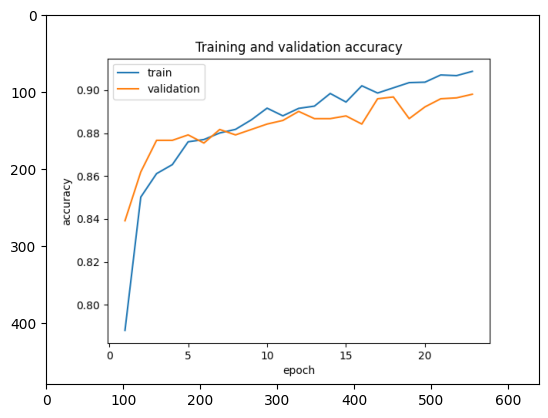

In [9]:
import matplotlib.image as mpimg
img_acc = mpimg.imread('/kaggle/working/training_graphs_and_logs/ResNet_epochs_25/accuracy.png')
imgplot = plt.imshow(img_acc)
plt.show()

**Plot the training and validation loss**

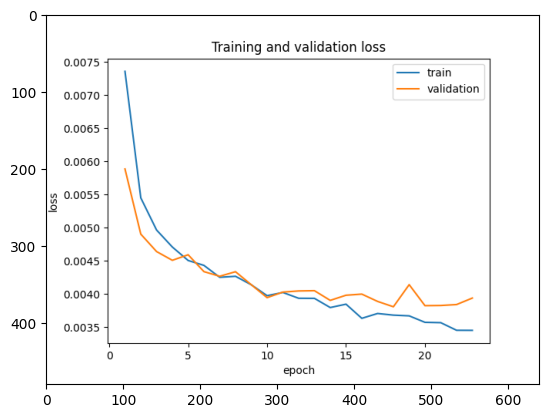

In [10]:
img_acc = mpimg.imread('/kaggle/working/training_graphs_and_logs/ResNet_epochs_25/loss.png')
imgplot = plt.imshow(img_acc)
plt.show()

# Testing

In [11]:
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(model, num_epochs, test_loader, additional_text='', augmentation='', model_structure=False):
    
    model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES)

    load_model('./trained_models', model, number_of_epochs=num_epochs, additional_text=additional_text,
               augmentation=augmentation)

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Evaluation metrics:\n")

    print('Accuracy: {:.2f}%'.format(accuracy * 100))
    # print('Precision: {:.2f}'.format(precision))
    # print('Recall: {:.2f}'.format(recall))
    # print('F1 Score: {:.2f}'.format(f1))

    # print out the number of parameters
    # total_params = sum(p.numel() for p in model.parameters())
    # print(f"Total number of parameters: {total_params}")

    # print out the model structure
    # if model_structure:
    #     summary(model=model,
    #             # (batch_size, color_channels, height, width)
    #             input_size=(64, 3, 32, 32),
    #             col_names=["input_size", "output_size", "num_params"],
    #             col_width=20,
    #             row_settings=["var_names"]
    #     )
        # print(model.eval())

    return y_true, y_pred

if __name__ == "__main__":

    model = models.resnet18()

    # Init the test-loader
    _, _, test_loader = get_dataloaders()
    class_labels = ['Benign', 'Malignant']

    # determine the evaluation metrics
    true_labels, predictions = evaluate(model, NUMBER_OF_EPOCHS, test_loader, augmentation='aug', model_structure=True)

Length of train_dataset: 9504
Length of Validation dataset: 2375
Length of test dataset: 2000
Evaluation metrics:

Accuracy: 90.85%


**Plot the confusion matrix**

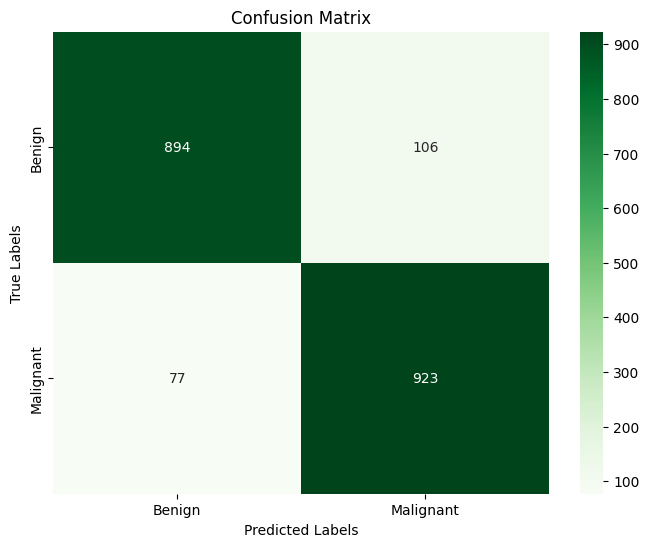

In [12]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Create classification report**

In [13]:
# Create classification report
report = classification_report(true_labels, predictions)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1000
           1       0.90      0.92      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



**Display some test images with their actual and predicted label**

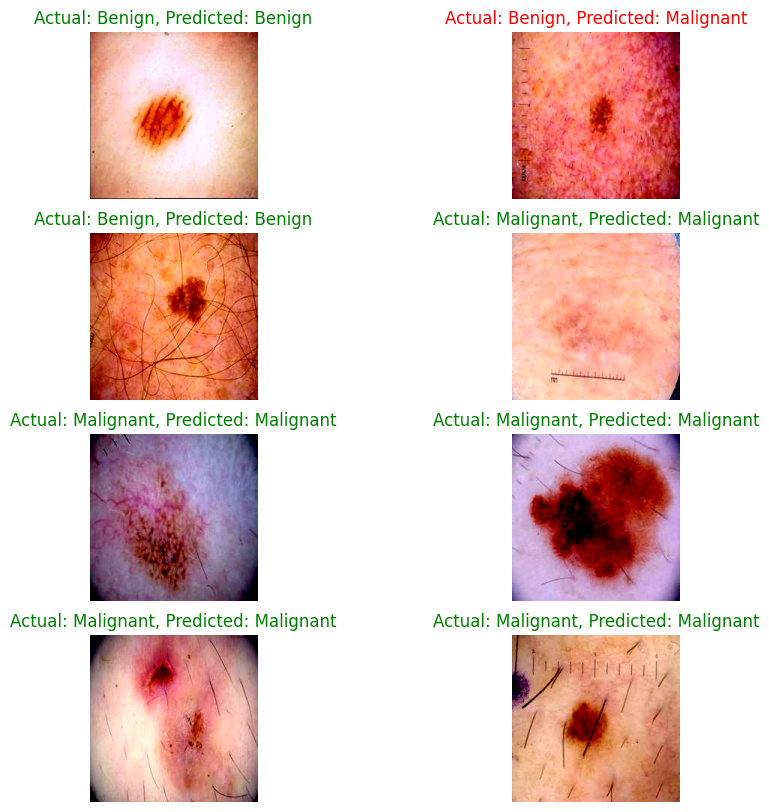

In [14]:
def display_random_predictions(model, num_epochs ,test_loader, class_labels, num_images=8, additional_text='', augmentation=''):
    load_model('./trained_models', model, number_of_epochs=num_epochs, additional_text=additional_text, augmentation=augmentation)
    # set model to evaluation mode
    model.eval()

    # get the total number of images in the test set
    total_images = len(test_loader.dataset)

    # randomly select 6 indices from the test set
    selected_indices = random.sample(range(total_images), num_images)

    images_so_far = 0
    # create a set of subplots in a grid, the first param is number of rows, the second param is the number of columns
    fig, axs = plt.subplots(num_images // 2, 2, figsize=(10, 10))

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # images is a tensor with shape (batch_size, channels, height, width)
            # images.size()[0] is the number of images in the batch
            for j in range(images.size()[0]):
                # exit the loop when the desired number of images is reached
                if images_so_far >= num_images:
                    break

                # Check if the current index is in the randomly selected indices
                if i * test_loader.batch_size + j in selected_indices:
                    #  accesses a specific subplot in the grid of subplots
                    ax = axs[images_so_far // 2, images_so_far % 2]
                    # turns of the axis
                    ax.axis('off')
                    #  sets the title of the subplot
                    # sets the title of the subplot with actual and predicted labels
                    actual_label = class_labels[labels[j].item()]
                    predicted_label = class_labels[preds[j].item()]

                    # Set the title color based on match or mismatch
                    title_color = 'green' if actual_label == predicted_label else 'red'

                    ax.set_title(f'Actual: {actual_label}, Predicted: {predicted_label}', color=title_color)

                    # convert the image tensor to NumPy array and transpose
                    img = np.transpose(images.cpu().data[j].numpy(), (1, 2, 0))

                    # # unnormalize if normalization was applied during data loading
                    img = img * np.array(MEAN) + np.array(STD)

                    # show the image in the subplot
                    ax.imshow(img)
                    # counting the processed images
                    images_so_far += 1

    # after all show the plot
    plt.show();


# Try the model on the testing dataset
display_random_predictions(model, NUMBER_OF_EPOCHS, test_loader, class_labels, augmentation='aug')